In [ ]:
import os
import pickle
from tqdm.notebook import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas

In [ ]:
od.download("https://www.kaggle.com/datasets/sakifhussain/banglalekha-image-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sayemaamin200041234
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sakifhussain/banglalekha-image-dataset


100%|██████████| 6.30G/6.30G [01:03<00:00, 107MB/s]


In [ ]:
BASE_DIR = '/content/banglalekha-image-dataset'

In [ ]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

102967424/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [ ]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # convert img pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    feature = model_new.predict(image, verbose = 0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/9154 [00:00<?, ?it/s]

In [ ]:
BANCAP_DIR = '/content/banglalekha-image-dataset/'
if not os.path.exists(BANCAP_DIR):
    os.makedirs(BANCAP_DIR)
with open(os.path.join(BANCAP_DIR, 'caps.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
captions_doc

'1.png,\tতিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।\n2.png,\tঅনেক মেয়ে মানুষ বসে আছে।\n3.png,\tঅনেক মানুষ একসাথে বসে কাজ করছে।\n4.png,\tছয় জন মানুষ দাড়িয়ে আছে।\n5.png,\tএক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে।\n6.png,\tআবছা অন্ধকারে এক জন মানুষ দাড়িয়ে আছে। পিছনে মানুষ গুলোর চেহারা বোঝা যাচ্ছে না।\n7.png,\tতিন জন মানুষ আছে। এক জন মাথায় ছাতা ধরে আছে।\n8.png,\tখালি গায়ে একটি বাচ্চা ছাতার নিচে বসে কাজ করছে। এখানে অনেক ইটের টুকরা আছে।\n9.png,\tএকজন মেয়ে মানুষ শাড়ি পরে দাড়িয়ে আছে। পেছনে একটি ঘর আছে।\n10.png,\tএকটি বাচ্চা মানুষ বসে কাজ করছে। সে একটি গেঞ্জি ও প্যান্ট পরিধান করে আছে। \n11.png,\tনিচে সবুজ মাঠ আছে। উপরে আছে নীল আকাশ ও সাদা মেঘ।\n12.png,\tঅল্প আলোতে একজন মানুষ বসে আছে।\n13.png,\tতিনজন ছেলে মানুষ আছে। একজন মানুষ সবজি বিক্রি করছে। একজন মানুষ রাস্তা দিয়ে রিক্সা নিয়ে যাচ্ছে।\n14.png,\tশাড়ি পরিহিত একজন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে আছে। পিছনে সবুজ গাছ আছে।\n15.png,\tআলোতে একটি শিশু দাড়িয়ে আছে।\n16.png,\tজলাশয় এর পাশে দুই জন মানুষ ও একটি শি

In [ ]:
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    image_id = tokens[0]
    if len(line) < 2:
        continue
    caption =  tokens[1:]
    #remove extensions from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #store the caption
    mapping[image_id].append(caption.strip())

  0%|          | 0/18309 [00:00<?, ?it/s]

In [ ]:
len(mapping)

9154

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # caption = caption.lower()
            # replace digits, special characters
            caption = caption.replace('[^\u0980-\u09FF]', '')
            #delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1']

['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।',
 'একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে।']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
#after preprocess of text
mapping['1']

['startseq তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। endseq',
 'startseq একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

18308

In [ ]:
all_captions[:10]

['startseq তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। endseq',
 'startseq একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। endseq',
 'startseq অনেক মেয়ে মানুষ বসে আছে। endseq',
 'startseq একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা। endseq',
 'startseq অনেক মানুষ একসাথে বসে কাজ করছে। endseq',
 'startseq টি ছোট ছেলে একজন শার্ট প্যান্ট দাড়িয়ে চেয়ে আছে আরেকজন বসে গার্মেন্টস কাজ করছে নীল শার্ট পরে তাদের পিছনে অনেকগুলো মহিলা বসে দাড়িয়ে কাজ করছে। endseq',
 'startseq ছয় জন মানুষ দাড়িয়ে আছে। endseq',
 'startseq "৬ জন মানুষ এলোমেলো দাড়িয়ে আছে তাদের মাঝে জন ছেলে জন পুরুষ তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে। endseq',
 'startseq এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে। endseq',
 'startseq "একটি মহিলা হালকা পানির উপরে দাড়িয়ে আছে শারি পরে মহিলার মুখ ডানদিকে ঘুরানো পানির রং হলুদ দেখাচ্ছে। endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

5722

In [ ]:
# get maximum lenth of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

38

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
split
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1,X2,y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n +=1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq,out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen= max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

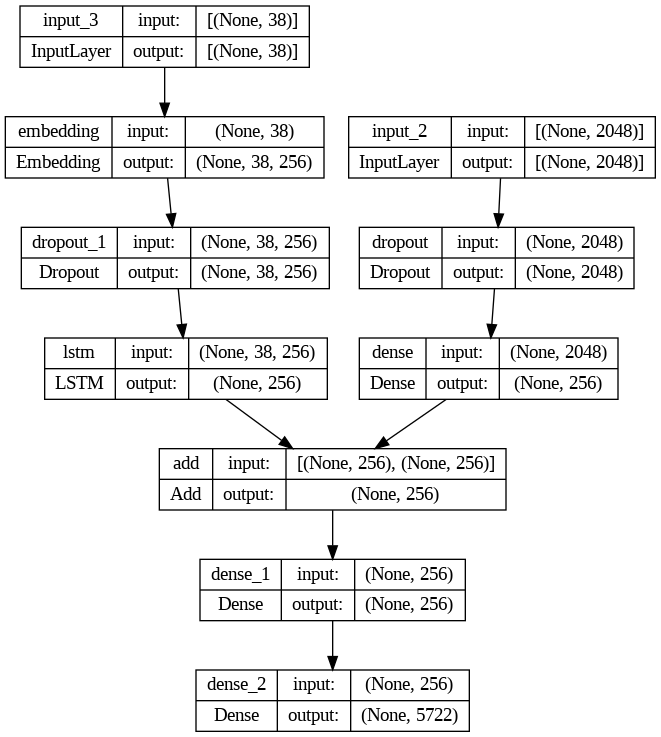

In [ ]:
# image feature layers
inputs1 = Input(shape = (2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256 , mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

# Merge 2 networks
model = Model(inputs= [inputs1, inputs2], outputs= outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#plot the model
plot_model(model, show_shapes= True)

In [ ]:
# model.layers[2].trainable = False

In [ ]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch = steps, verbose = 1)

257/257 [==============================] - 533s 2s/step - loss: 2.1643


In [ ]:
# # save the model
# model.save(WORKING_DIR+'/densenet101.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose = 0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        #append word as input for generating next word
        in_text += " "+word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# validate with text data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
print("BLEU-1: %f" %corpus_bleu(actual, predicted, weights= (1.0, 0, 0, 0)))
print("BLEU-2: %f" %corpus_bleu(actual, predicted, weights= (0.5, 0.5, 0, 0)))

  0%|          | 0/916 [00:00<?, ?it/s]

BLEU-1: 0.501199
BLEU-2: 0.321897


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------------Actual--------------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------------Predicted------------------------')
    print(y_pred)
    plt.imshow(image)

---------------------------Actual--------------------------
startseq তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। endseq
startseq একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। endseq
--------------------------Predicted------------------------
startseq একজন পুরুষ বসে আছে। endseq


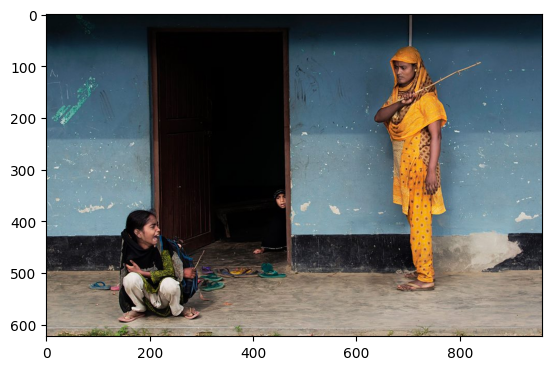

In [ ]:
generate_caption("1.png")

---------------------------Actual--------------------------
startseq দোকানের পাশে একজন মানুষ বসে আছে। endseq
startseq এক্যি পুরুষ সাদা শার্ট সোয়েটার প্যান্ট পরে হাতে একটি পেপার নিয়ে একটি টুলের উপরে বসে আছে তার পাশে একটি দোকান। endseq
--------------------------Predicted------------------------
startseq একজন পুরুষ বসে আছে। endseq


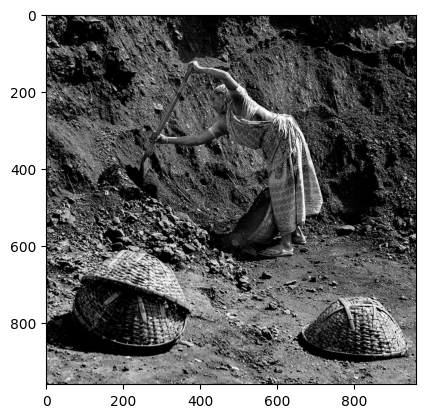

In [ ]:
generate_caption("100.png")

---------------------------Actual--------------------------
startseq একজন হিজাব পরিহিত বয়স্ক নারী আছে। endseq
startseq একজন মহিলার কাঁধে একটি কবুতর। endseq
--------------------------Predicted------------------------
startseq একজন নারী আছে। endseq


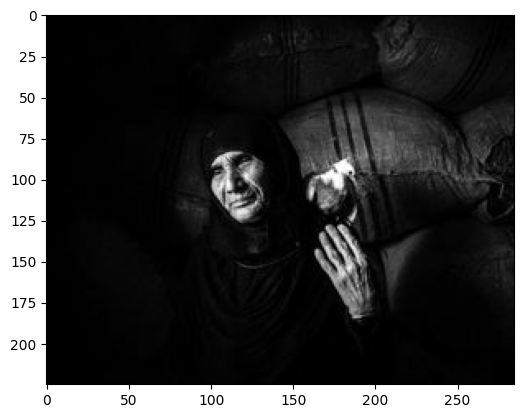

In [ ]:
generate_caption("1015.png")

---------------------------Actual--------------------------
startseq দুইজন নারী দাড়িয়ে আছে। endseq
startseq জন মহিলা কিছু পোস্টার দেখছে। endseq
--------------------------Predicted------------------------
startseq একজন পুরুষ বসে আছে। endseq


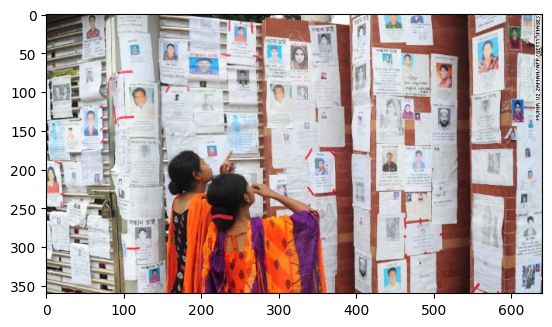

In [ ]:
generate_caption("1019.png")

---------------------------Actual--------------------------
startseq একজন দম্পতি একসাথে আছে যেখানে মেয়েটা দোলনায় বসে আর ছেলে মেয়েটার পিছনে দাঁড়িয়ে একে অপরের দিকে তাকিয়ে আছে। endseq
startseq দোলনায় শাড়ি পরিহিত একজন নারী বসে আছে। পাশে পাঞ্জাবি পরিহিত একজন পুরুষ দাড়িয়ে আছে। endseq
--------------------------Predicted------------------------
startseq নৌকায় কয়েকজন মানুষ আছে। endseq


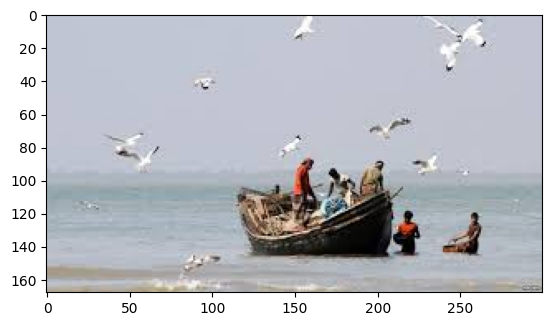

In [ ]:
generate_caption("2019.png")


---------------------------Actual--------------------------
startseq লাল গেঞ্জি পরা একটা লোক কোমড় পানিতে নেমে একটা লাল গরুকে গোসল করাচ্ছে। endseq
startseq পানিতে একজন পুরুষ একটি গরু দেখা যাচ্ছে। endseq
--------------------------Predicted------------------------
startseq কয়েকজন পুরুষ আছে। endseq


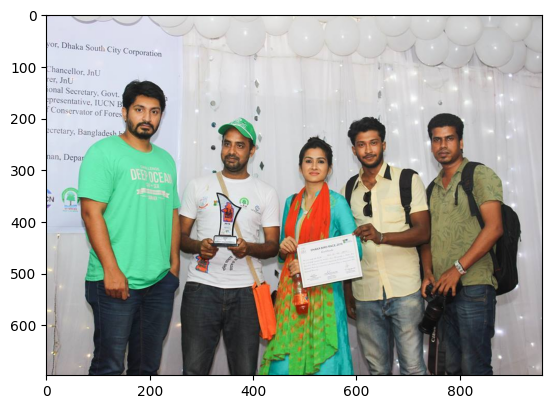

In [ ]:
generate_caption("2119.png")


---------------------------Actual--------------------------
startseq চারজন পুরুষ একজন নারী দাড়িয়ে আছে। endseq
startseq জন দাড়িয়ে আছে যার মাঝে জন ছেলে হাতে লাটি নিয়ে আছে এবং জন আদিবাসী মহিলা তাদের সাথে। endseq
--------------------------Predicted------------------------
startseq কয়েকজন পুরুষ আছে। endseq


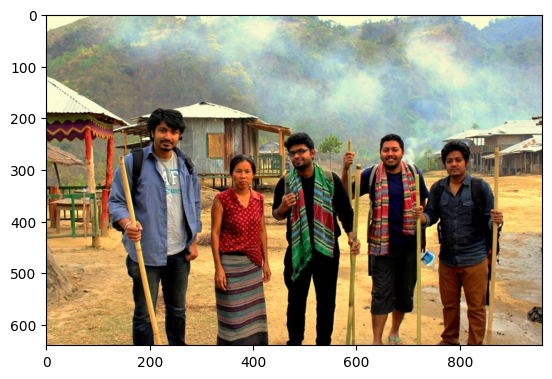

In [ ]:
generate_caption("3119.png")


---------------------------Actual--------------------------
startseq একজন পুরুষ চশমা পরে আছে। endseq
startseq চখে গ্লাস পরা একটি ছেলে মানুষ। endseq
--------------------------Predicted------------------------
startseq একটা ছোট ছেলে একটা মেয়ের ঘারে ধরে হাঁসি মুখে দাঁড়িয়ে আছে। endseq


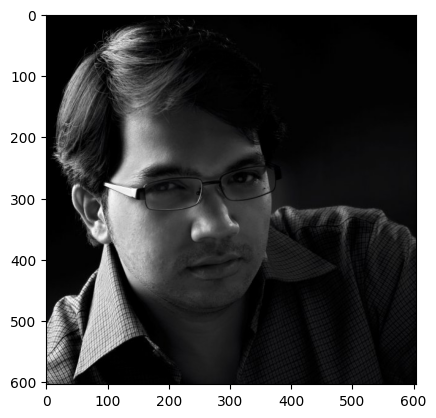

In [ ]:
generate_caption("519.png")


---------------------------Actual--------------------------
startseq কয়েকজন শাড়ি পরা মহিলা মাথায় লাল কাপড় বেঁধে একসাথে বসে আছে। endseq
startseq অনেকগুলো নারী বসে আছে। endseq
--------------------------Predicted------------------------
startseq কয়েকজন মানুষ আছে। endseq


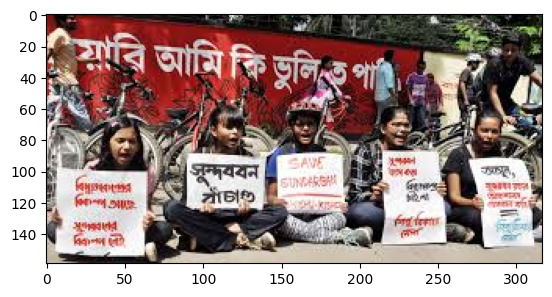

In [ ]:
generate_caption("2340.png")


---------------------------Actual--------------------------
startseq চারজন পুরুষ পাশাপাশি দাড়িয়ে আছে। endseq
startseq চারজন লোক একসাথে দাড়িয়ে ছবি তুলছে পিছনে কয়েকটা ছবি দেখা যাচ্ছে। endseq
--------------------------Predicted------------------------
startseq দুইজন নারী দুইজন পুরুষ আছে। endseq


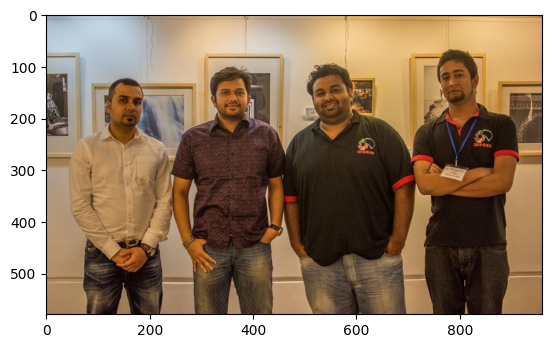

In [ ]:
generate_caption("4302.png")


In [ ]:
generate_caption("8888.png")


In [ ]:
generate_caption("5556.png")


In [ ]:
generate_caption("4432.png")


In [ ]:
generate_caption("3309.png")


In [ ]:
generate_caption("6666.png")


In [ ]:
generate_caption("7611.png")


In [ ]:
generate_caption("8111.png")


In [ ]:
generate_caption("6000.png")
